### Important Modules

In [ ]:
import numpy as np
import csv
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import deque
from sklearn.decomposition import PCA

## Read and Plot Function

In [ ]:

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [ ]:

def plot(path_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(path_XYs):
#         c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def plot_with_num(path_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(path_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)

            # Calculate the midpoint for annotation
            midpoint_index = len(XY)//2
            midpoint = XY[midpoint_index]

            # Annotate the segment with its index
            ax.text(midpoint[0], midpoint[1], str(i), fontsize=12, color='red', ha='center', va='bottom')

    ax.set_aspect('equal')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Plot with Segment Indices')
    plt.grid(True)
    plt.show()


## Detecting Corner Points and dividing into segments

In [ ]:

def plot_points_with_corners(path_XYs, corners):
    """
    Plot paths and detected corners.

    Parameters:
    - path_XYs: List of paths, each path being a list of XY arrays
    - corners: Numpy array of detected corners
    """
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(path_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)

    ax.set_aspect('equal')
    if corners.size > 0:  # Check if corners is not empty
        ax.scatter(corners[:, 0], corners[:, 1], color='red', label='Corners', marker='x')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Detected Corners')
    ax.legend()
    plt.show()

def compute_curvature(points):
    # Compute first and second derivatives
    dx = np.gradient(points[:, 0])
    dy = np.gradient(points[:, 1])
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    # Compute curvature
    curvature = np.abs(ddx * dy - dx * ddy) / np.power(dx**2 + dy**2, 1.5)
    return curvature

def detect_corners_via_curvature(points, curvature_threshold=0.1, window_size=3):
    curvature = compute_curvature(points)

    # Find local maxima in curvature
    corner_indices = []
    for i in range(window_size, len(points) - window_size):
        local_max = np.max(curvature[i-window_size:i+window_size])
        if curvature[i] == local_max and curvature[i] > curvature_threshold:
            corner_indices.append(i)

    return corner_indices

def detect_corners_for_plot(points, curvature_threshold=0.1, window_size=3):
    curvature = compute_curvature(points)

    # Find local maxima in curvature
    corners = []
    for i in range(window_size, len(points) - window_size):
        local_max = np.max(curvature[i-window_size:i+window_size])
        if curvature[i] == local_max and curvature[i] > curvature_threshold:
            corners.append(points[i])

    return np.array(corners)


def plot_points_with_corners_new(points, corners):
    plt.plot(points[:, 0], points[:, 1], label='Shape')
    if len(corners) > 0:
        plt.scatter(corners[:, 0], corners[:, 1], color='red', label='Corners', marker='x')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Detected Corners')
    plt.legend()
    plt.show()


def split_segments_at_corners(points, corner_indices):
    """Split segments at detected corners."""
    segments = []
    start_idx = 0

    for corner_idx in corner_indices:
        segments.append(points[start_idx:corner_idx+1])
        start_idx = corner_idx

    # Add the last segment
    if start_idx < len(points):
        segments.append(points[start_idx:])

    return segments


def update_frag_with_segments(isolated, curvature_threshold=0.2):
    """Update isolated with separated segments after corner detection."""
    newfrag = []

    for i in range(len(isolated)):
        for j in range(len(isolated[i])):
            points = isolated[i][j]  # Accessing the first element of each sub-list
            corner_indices = detect_corners_via_curvature(points, curvature_threshold=curvature_threshold)

            # Split the points into segments at detected corners
            segments = split_segments_at_corners(points, corner_indices)

            # Add each segment to the newfrag list
            for segment in segments:
                newfrag.append([segment])

    return newfrag




def perpendicular_distance(point, line_start, line_end):
    """Calculate the perpendicular distance from a point to a line defined by two endpoints."""
    x0, y0 = point
    x1, y1 = line_start
    x2, y2 = line_end
    # Line equation: Ax + By + C = 0
    A = y2 - y1
    B = x1 - x2
    C = x2 * y1 - x1 * y2
    # Distance calculation with handling for zero denominator
    denominator = np.sqrt(A**2 + B**2)
    distance = np.abs(A * x0 + B * y0 + C) / denominator if denominator != 0 else np.inf
    return distance

def max_distance_points(points):
    """Find two points in the set that are the farthest apart."""
    max_dist = 0
    start_point = None
    end_point = None

    for i, p1 in enumerate(points):
        for p2 in points[i+1:]:
            dist = np.linalg.norm(p1 - p2)
            if dist > max_dist:
                max_dist = dist
                start_point = p1
                end_point = p2

    return start_point, end_point

def plot_points_and_regression_line(points, y_pred):
    """Plot the points and regression line."""
    plt.scatter(points[:, 0], points[:, 1], color='blue', label='Data Points')
    plt.plot(points[:, 0], y_pred, color='red', linestyle='--', label='Regression Line')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Line Fit with Regression Line')
    plt.legend()
    plt.grid(True)
    plt.show()

def angle_based_line_check(points, angle_threshold=0.08, outlier_ratio=0.1):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]

    # Fit linear regression model
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # Find the two points that are the farthest apart
    line_start, line_end = max_distance_points(points)
    base_distance = np.linalg.norm(line_end - line_start)

    # Calculate tan(theta) for each point
    tan_thetas = []
    for point in points:
        perpendicular = perpendicular_distance(point, line_start, line_end)
        tan_theta = perpendicular / base_distance if base_distance != 0 else np.inf
        tan_thetas.append(tan_theta)

    tan_thetas = np.array(tan_thetas)

    # Check if the majority of the points have tan(theta) below the threshold
    inliers = np.sum(tan_thetas < angle_threshold)
    collinear_ratio = inliers / len(points)

    # Plot only if needed
    # plot_points_and_regression_line(points, y_pred)

    return collinear_ratio >= (1 - outlier_ratio)

def make_straight_line(start, end, num_points):
    """Generate equally spaced points between start and end."""
    return np.linspace(start, end, num=num_points)

def process_segments(newfrag, angle_threshold=0.08, outlier_ratio=0.1):
    """Process each segment and replace with straight line if close to collinear."""
    new_frag_with_lines = []

    for segment in newfrag:
        points = segment[0]  # Access the points in the segment
        if angle_based_line_check(points, angle_threshold, outlier_ratio):
            start, end = max_distance_points(points)
            # Create a straight line with the same number of points
            straight_line_points = make_straight_line(start, end, len(points))
            new_frag_with_lines.append([straight_line_points])
        else:
            new_frag_with_lines.append(segment)

    return new_frag_with_lines

def plot_polyline(XYs):
    """Plot the polyline for visualization."""
    fig, ax = plt.subplots()
    ax.plot(XYs[:, 0], XYs[:, 1], marker='o')
    ax.set_aspect('equal')
    plt.show()


In [ ]:
class UnionFind:
    """Union-Find data structure (Disjoint Set Union, DSU) to manage connected components."""
    def __init__(self, size):
        self.parent = list(range(size+1))
        self.rank = [1] * (size+1)

    def find(self, u):
        if self.parent[u] != u:
            self.parent[u] = self.find(self.parent[u])
        return self.parent[u]

    def union(self, u, v):
        rootU = self.find(u)
        rootV = self.find(v)
        if rootU != rootV:
            if self.rank[rootU] > self.rank[rootV]:
                self.parent[rootV] = rootU
            elif self.rank[rootU] < self.rank[rootV]:
                self.parent[rootU] = rootV
            else:
                self.parent[rootV] = rootU
                self.rank[rootU] += 1

def is_close(point1, point2, threshold):
    """Check if two points are within a certain proximity threshold."""
    return np.linalg.norm(point1 - point2) < threshold

import numpy as np

def are_parallel(segment1, segment2, angle_threshold=0.08):
    """Check if two segments are closely parallel or anti-parallel."""
    def direction_vector(segment):
        return segment[-1] - segment[0]

    dir1 = direction_vector(segment1)
    dir2 = direction_vector(segment2)

    # Normalize the direction vectors
    norm1 = np.linalg.norm(dir1)
    norm2 = np.linalg.norm(dir2)
    if norm1 == 0 or norm2 == 0:
        return False

    dir1 = dir1 / norm1
    dir2 = dir2 / norm2

    # Calculate the cosine of the angle between the two direction vectors
    cos_angle = np.dot(dir1, dir2)
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))

    # Check if the angle is within the threshold (close to 0 or 180 degrees)
    return np.abs(angle) < angle_threshold or np.abs(angle - np.pi) < angle_threshold



def process_and_merge_segments_with_graph(newfrag,is_straight_line, angle_threshold=0.15, outlier_ratio=0.1, proximity_factor=1/20):
    """Process each segment to merge them using graph-based approach."""
    n = len(newfrag)
    uf = UnionFind(n)

    # Create edges in the graph based on proximity and parallelism
    for i in range(n):
        for j in range(i+1, n):
            if is_straight_line[i] and is_straight_line[j]:

                current_segment = newfrag[i][0]
                next_segment = newfrag[j][0]

                current_end = current_segment[-1]
                current_start = current_segment[0]
                next_start = next_segment[0]
                next_end = next_segment[-1]

                # Calculate proximity threshold
                current_length = np.linalg.norm(current_segment[-1] - current_segment[0])
                next_length = np.linalg.norm(next_segment[-1] - next_segment[0])
                proximity_threshold = (current_length + next_length) * proximity_factor

                distances = [
                    np.linalg.norm(current_end - next_start),
                    np.linalg.norm(current_end - next_end),
                    np.linalg.norm(current_start - next_end),
                    np.linalg.norm(current_start - next_start)
                ]
                min_distance = min(distances)


            # Check proximity and potential merging
                if min_distance < proximity_threshold:
                    # Check if segments are closely parallel
                    # print(i, j)
                    if distances[0] == min_distance:
                        midpoint = current_end
                        new_segment1 = np.vstack((current_segment, [midpoint]))
                        new_segment2 = np.vstack(([midpoint], next_segment))
                        newfrag[i][0] = make_straight_line(new_segment1[0], new_segment1[-1], len(new_segment1))
                        newfrag[j][0] = make_straight_line(new_segment2[0], new_segment2[-1], len(new_segment2))
                    elif distances[1] == min_distance:
                        midpoint = current_end
                        new_segment1 = np.vstack((current_segment, [midpoint]))
                        new_segment2 = np.vstack(([midpoint], next_segment[::-1]))
                        newfrag[i][0] = make_straight_line(new_segment1[0], new_segment1[-1], len(new_segment1))
                        newfrag[j][0] = make_straight_line(new_segment2[0], new_segment2[-1], len(new_segment2))
                    elif distances[2] == min_distance:
                        midpoint = current_start
                        new_segment2 = np.vstack((next_segment, [midpoint]))
                        new_segment1 = np.vstack(([midpoint], current_segment))
                        newfrag[i][0] = make_straight_line(new_segment1[0], new_segment1[-1], len(new_segment1))
                        newfrag[j][0] = make_straight_line(new_segment2[0], new_segment2[-1], len(new_segment2))
                    elif distances[3] == min_distance:
                        midpoint = current_start
                        new_segment2 = np.vstack((next_segment[::-1], [midpoint]))
                        new_segment1 = np.vstack(([midpoint], current_segment))
                        newfrag[i][0] = make_straight_line(new_segment1[0], new_segment1[-1], len(new_segment1))
                        newfrag[j][0] = make_straight_line(new_segment2[0], new_segment2[-1], len(new_segment2))
                    if are_parallel(current_segment, next_segment, angle_threshold):
                        uf.union(i, j)


    # Collect all connected components and merge them
    component_map = {}
    for i in range(n):
        root = uf.find(i)
        if root not in component_map:
            component_map[root] = []
        component_map[root].append(i)

    # print(component_map)

    merged_fragments = []
    for component_indices in component_map.values():
        combined_points = np.vstack([newfrag[i][0] for i in component_indices])
        if len(component_indices) == 1:
            merged_fragments.append([combined_points])
        else:
            # combined_points = np.vstack([newfrag[i][0] for i in component_indices])

            # Find the start and end points based on x-coordinate first, then y-coordinate
            start = combined_points[np.lexsort((combined_points[:, 1], combined_points[:, 0]))][0]
            end = combined_points[np.lexsort((combined_points[:, 1], combined_points[:, 0]))][-1]
            straight_line_points = make_straight_line(start, end, len(combined_points))
            merged_fragments.append([straight_line_points])
            # print("Start:", start, "End:", end)

    return merged_fragments


def process_and_merge_corners(newfrag, is_straight_line, angle_threshold=0.15, outlier_ratio=0.1, proximity_factor=1/20):
    """Process each segment to merge them using graph-based approach."""
    n = len(newfrag)

    # Create edges in the graph based on proximity and parallelism
    for i in range(n):
        current_segment = newfrag[i][0]
        current_end = current_segment[-1]
        current_start = current_segment[0]
        mid = current_segment[(len(current_segment)//2)]
        current_length = np.linalg.norm(current_end - mid)
        next_length = np.linalg.norm(current_start - mid)
        proximity_threshold = (current_length + next_length) * proximity_factor

        min_distance = np.linalg.norm(current_end - current_start)

        if min_distance < proximity_threshold:
            newfrag[i][0] = np.vstack((current_segment, [current_start]))

        for j in range(i + 1, n):
            current_segment = newfrag[i][0]
            next_segment = newfrag[j][0]

            current_end = current_segment[-1]
            current_start = current_segment[0]
            next_start = next_segment[0]
            next_end = next_segment[-1]

            # Calculate proximity threshold
            current_length = np.linalg.norm(current_segment[-1] - current_segment[0])
            next_length = np.linalg.norm(next_segment[-1] - next_segment[0])
            proximity_threshold = (current_length + next_length) * proximity_factor

            distances = [
                np.linalg.norm(current_end - next_start),
                np.linalg.norm(current_end - next_end),
                np.linalg.norm(current_start - next_end),
                np.linalg.norm(current_start - next_start)
            ]
            min_distance = min(distances)


            # Check proximity and potential merging
            if min_distance < proximity_threshold:
                if is_straight_line[i] and is_straight_line[j]:
                    if min_distance > 0:
                        if distances[0] == min_distance:
                            midpoint = current_end
                            new_segment1 = np.vstack((current_segment, [midpoint]))
                            new_segment2 = np.vstack(([midpoint], next_segment))
                            newfrag[i][0] = make_straight_line(new_segment1[0], new_segment1[-1], len(new_segment1))
                            newfrag[j][0] = make_straight_line(new_segment2[0], new_segment2[-1], len(new_segment2))
                        elif distances[1] == min_distance:
                            midpoint = current_end
                            new_segment1 = np.vstack((current_segment, [midpoint]))
                            new_segment2 = np.vstack(([midpoint], next_segment[::-1]))
                            newfrag[i][0] = make_straight_line(new_segment1[0], new_segment1[-1], len(new_segment1))
                            newfrag[j][0] = make_straight_line(new_segment2[0], new_segment2[-1], len(new_segment2))
                        elif distances[2] == min_distance:
                            midpoint = current_start
                            new_segment2 = np.vstack((next_segment, [midpoint]))
                            new_segment1 = np.vstack(([midpoint], current_segment))
                            newfrag[i][0] = make_straight_line(new_segment1[0], new_segment1[-1], len(new_segment1))
                            newfrag[j][0] = make_straight_line(new_segment2[0], new_segment2[-1], len(new_segment2))
                        elif distances[3] == min_distance:
                            midpoint = current_start
                            new_segment2 = np.vstack((next_segment[::-1], [midpoint]))
                            new_segment1 = np.vstack(([midpoint], current_segment))
                            newfrag[i][0] = make_straight_line(new_segment1[0], new_segment1[-1], len(new_segment1))
                            newfrag[j][0] = make_straight_line(new_segment2[0], new_segment2[-1], len(new_segment2))
                else:
                    if distances[0] == min_distance:
                        midpoint = current_end
                        newfrag[i][0] = np.vstack((current_segment, [midpoint]))
                        newfrag[j][0] = np.vstack(([midpoint], next_segment))
                    elif distances[1] == min_distance:
                        midpoint = current_end
                        newfrag[i][0] = np.vstack((current_segment, [midpoint]))
                        newfrag[j][0] = np.vstack(([midpoint], next_segment[::-1]))
                    elif distances[2] == min_distance:
                        midpoint = current_start
                        newfrag[j][0] = np.vstack((next_segment, [midpoint]))
                        newfrag[i][0] = np.vstack(([midpoint], current_segment))
                    elif distances[3] == min_distance:
                        midpoint = current_start
                        newfrag[j][0] = np.vstack((next_segment[::-1], [midpoint]))
                        newfrag[i][0] = np.vstack(([midpoint], current_segment))

    return newfrag


## Detecting Cycles

In [ ]:

def find_cycles_in_graph(graph, num_points):
    visited = [False] * num_points
    parent = [-1] * num_points
    cycles = []

    def dfs(v, start, path):
        visited[v] = True
        path.append(v)

        for neighbor in graph[v]:
            if not visited[neighbor]:
                parent[neighbor] = v
                dfs(neighbor, start, path)
            elif neighbor == start and len(path) > 2:
                # Found a cycle
                cycle = path[:]
                cycles.append(cycle)

        path.pop()
        visited[v] = False

    # Start DFS from each node
    for start in range(num_points):
        if not visited[start]:
            dfs(start, start, [])

    ordered_cycles = set()
    correct_cycles = set()
    for cycle in cycles:
        # Create a map for cycle elements to their indices
        cycle_map = {cyc: i for i, cyc in enumerate(cycle)}

        # Sort the cycle and use the map to order it correctly
        unique_cycles = sorted(set(cycle))

        if tuple(unique_cycles) not in ordered_cycles:
            # Initialize new_cycles with None values
            new_cycles = [None] * (len(unique_cycles) + 1)
            for cyc in unique_cycles:
                new_cycles[cycle_map[cyc]] = cyc
            new_cycles[len(unique_cycles)] = new_cycles[0]
            # Convert new_cycles to tuple for immutability and to use in a set
            ordered_cycles.add(tuple(unique_cycles))
            correct_cycles.add(tuple(new_cycles))

    # Convert tuples back to lists

    return [list(cycle) for cycle in correct_cycles]


# Step 3 & 4: Handle multiple edges and find all cycle combinations.
def find_all_cycle_combinations(cycles, segment_map, N, node_list):
    # Generate all combinations of 2 elements from 0 to N-1
    cycle_combinations = list(combinations(range(N), 2))

    all_cycle_combinations = []

    # For each combination of nodes, get possible edge pairs
    for a, b in cycle_combinations:
        node_a = node_list[a]
        node_b = node_list[b]
        # Get the list of edges for the pair (node_a, node_b)
        edge_list = segment_map.get((node_a, node_b), []) + segment_map.get((node_b, node_a), [])

        # If there are more than one edge, find all unique pairs
        if len(edge_list) > 1:
            cycle_comb = []
            for i in range(len(edge_list)):
                for j in range(i + 1, len(edge_list)):

                    cycle_comb.append([edge_list[i], edge_list[j]])
            all_cycle_combinations.extend(cycle_comb)

    # Self loops for circle and ellipses
    for i in range(N):
         node_a = node_list[i]
         edge_list = segment_map.get((node_a, node_a), [])
         for loop in edge_list:
              all_cycle_combinations.append([loop])

    # All other cycles
    for cycle in cycles:
        cycle_size = len(cycle)

        def find_all_cycles(index, current_cycle):
            if index == cycle_size - 1:
                all_cycle_combinations.append(current_cycle[:])  # Append a copy of current_cycle
                return

            a, b = node_list[cycle[index]], node_list[cycle[index + 1]]
            segments_ab = segment_map.get((a, b), []) + segment_map.get((b, a), [])
            for edge in segments_ab:
                current_cycle.append(edge)
                find_all_cycles(index + 1, current_cycle)
                current_cycle.pop()

        find_all_cycles(0, [])

    return all_cycle_combinations



## Detecting the shape and regularizing it

In [ ]:
def corner_detection(sides):
    # Initialize the list with the first side's endpoints
    corner_points = deque([sides[0][0], sides[0][-1]])

    # Iterate over the remaining sides
    for i in range(1, len(sides) - 1):
        start_point = sides[i][0]  # First point of the side
        end_point = sides[i][-1]   # Last point of the side

        # Check if start_point is already in corner_points
        if np.array_equal(start_point, corner_points[-1]) or np.array_equal(start_point, corner_points[0]):
            if np.array_equal(start_point, corner_points[-1]):
                corner_points.append(end_point)
            else:
                corner_points.appendleft(end_point)

        # Check if end_point is already in corner_points
        else:
            if np.array_equal(end_point, corner_points[-1]):
                corner_points.append(start_point)
            else:
                corner_points.appendleft(start_point)

    return np.array(corner_points)


In [333]:
def is_circle(YZ, tolerance=0.1):

    # Calculate the centroid (central point)
    XY = []
    temp = []
    for i in YZ:
        temp.extend(i)
    XY.append(np.array(temp))
    if len(XY)!= 1:
      return False
    centroid = np.mean(XY[0], axis=0)
    # Calculate the distance of each point from the centroid (radii)
    radii = np.linalg.norm(XY[0] - centroid, axis=1)
    # Calculate the mean radius
    mean_radius = np.mean(radii)
    # Calculate the deviations from the mean radius
    delta_radii = np.abs(radii - mean_radius) / mean_radius
    # Check if 90% of these values are within the tolerance
    within_tolerance = np.sum(delta_radii < tolerance) / len(delta_radii)
    return within_tolerance >= 0.9

def calculate_angle(p1, p2, p3):
    v1 = p1 - p2
    v2 = p3 - p2
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    return np.degrees(angle)

def is_square(XY, angle_tolerance=5, ratio_tolerance=1.1):
    if len(XY) != 4:
        return False
    points = corner_detection(XY)

    # Calculate the distances between consecutive points (sides)
    sides = [
        np.linalg.norm(points[i] - points[(i + 1) % 4]) for i in range(4)
    ]
    # Calculate the angles at each corner
    angles = [
        calculate_angle(points[i - 1], points[i], points[(i + 1) % 4]) for i in range(4)
    ]
    # Check if all angles are within the tolerance range of 90 degrees
    if np.allclose(angles, 90, atol=angle_tolerance):
        # Check the ratio of the max side length to the min side length
        max_side = max(sides)
        min_side = min(sides)
        side_ratio = max_side / min_side

        if side_ratio < ratio_tolerance:
            return True
        else:
          return False
    else:
        return False

def is_rectangle(XY, angle_tolerance=5, ratio_tolerance=1.1):
    if len(XY) != 4:
        return False
    points = corner_detection(XY)

    # Calculate the distances between consecutive points (sides)
    sides = [
        np.linalg.norm(points[i] - points[(i + 1) % 4]) for i in range(4)
    ]
    # Calculate the angles at each corner
    angles = [
        calculate_angle(points[i - 1], points[i], points[(i + 1) % 4]) for i in range(4)
    ]

    # Check if all angles are within the tolerance range of 90 degrees
    if np.allclose(angles, 90, atol=angle_tolerance):
        # Check the ratio of the max side length to the min side length
        max_side = max(sides)
        min_side = min(sides)
        side_ratio = max_side / min_side

        if side_ratio >= ratio_tolerance:
            return True
        else:
          return False
    else:
        return False

def is_regular_polygon(XY, side_ratio_tolerance=1.1, angle_tolerance=5):
    # Assuming corner_detection(XY) returns the points in order around the polygon
    points = corner_detection(XY)
    num_points = len(points)

    if num_points < 3:
        return False
    # Calculate the distances between consecutive points (sides of the polygon)
    sides = [
        np.linalg.norm(points[i] - points[(i + 1) % num_points]) for i in range(num_points)
    ]
    # Calculate the angles between consecutive sides
    angles = []
    for i in range(num_points):
        v1 = points[i] - points[(i - 1) % num_points]
        v2 = points[(i + 1) % num_points] - points[i]
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        angles.append(np.degrees(angle))
    # Check if the ratio of min side to max side is within the tolerance
    min_side = min(sides)
    max_side = max(sides)
    side_ratio = min_side / max_side
    sides_equal = side_ratio >= (1 / side_ratio_tolerance)
    # Calculate the expected interior angle for a regular polygon
    expected_angle = (num_points - 2) * 180 / num_points
    # Check if all angles are within the specified tolerance range of the expected angle
    angles_equal = np.allclose(angles, expected_angle, atol=angle_tolerance)
    # Return True if both sides and angles meet the criteria
    return sides_equal and angles_equal


def is_star_shape(sides, tolerance=1.1):
    XY = np.vstack(sides)
    points = corner_detection(sides)
    if len(points)!= 10:
      return False
    # Calculate the centroid (central point)
    centroid = np.mean(XY, axis=0)
    # Calculate the distance of each point from the centroid
    distances = np.linalg.norm(points - centroid, axis=1)
    # Find the local maxima and minima in distances (peaks and valleys)
    disA = []
    disB= []
    for i in range(0, len(distances),2):
      disA.append(distances[i])
    for i in range(1, len(distances),2):
      disB.append(distances[i])
    min_side = min(disA)
    max_side = max(disA)
    side_ratio = min_side / max_side
    sides_equalA = side_ratio >= (1 / tolerance)
    min_side = min(disB)
    max_side = max(disB)
    side_ratio = min_side / max_side
    sides_equalB = side_ratio >= (1 / tolerance)

    return sides_equalA and sides_equalB


In [348]:
def regularize_circle(YZ):
    XY = []
    temp = []
    for i in YZ:
        temp.extend(i)
    XY.append(np.array(temp))
    if len(XY)!= 1:
      return False
    centroid = np.mean(XY[0], axis=0)
    mean_radius = np.mean(np.linalg.norm(XY[0] - centroid, axis=1))
    angles = np.arctan2(XY[0][:, 1] - centroid[1], XY[0][:, 0] - centroid[0])
    regularized_XY = np.array([centroid + mean_radius * np.array([np.cos(a), np.sin(a)]) for a in angles])
    return regularized_XY


def regularize_square(XY):
    points = corner_detection(XY)
    p0, p1 = points[0], points[1]

    side_length = np.linalg.norm(p1 - p0)
    direction = (p1 - p0) / np.linalg.norm(p1 - p0)
    rotation_matrix = np.array([[0, -1], [1, 0]])

    p2 = p1 + side_length * np.dot(rotation_matrix, direction)
    p3 = p0 + side_length * np.dot(rotation_matrix, direction)

    regularized_points = np.array([p0, p1, p2, p3])  # Forming the square

    full_square_points = np.vstack([
        make_straight_line(regularized_points[i], regularized_points[(i + 1) % 4], 100)
        for i in range(4)
    ])

    return full_square_points

def regularize_rectangle(XY):
    points = corner_detection(XY)
    p0, p1, p2 = points[0], points[1], points[2]

    side_length1 = np.linalg.norm(p1 - p0)
    side_length2 = np.linalg.norm(p2 - p1)
    direction1 = (p1 - p0) / np.linalg.norm(p1 - p0)
    rotation_matrix = np.array([[0, -1], [1, 0]])

    p3 = p1 + side_length2 * np.dot(rotation_matrix, direction1)
    p4 = p0 + side_length2 * np.dot(rotation_matrix, direction1)

    regularized_points = np.array([p0, p1, p3, p4])  # Forming the rectangle

    full_rectangle_points = np.vstack([
        make_straight_line(regularized_points[i], regularized_points[(i + 1) % 4], 100)
        for i in range(4)
    ])

    return full_rectangle_points

def regularize_regular_polygon(XY):
    points = corner_detection(XY)
    num_points = len(points)
    centroid = np.mean(points, axis=0)
    avg_distance = np.mean(np.linalg.norm(points - centroid, axis=1))
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    regularized_points = np.array([centroid + avg_distance * np.array([np.cos(a), np.sin(a)]) for a in angles])
    full_polygon_points = []
    for i in range(num_points):
        start_point = regularized_points[i]
        end_point = regularized_points[(i + 1) % num_points]
        for t in np.linspace(0, 1, len(np.vstack(XY)), endpoint=False):
            interpolated_point = start_point * (1 - t) + end_point * t
            full_polygon_points.append(interpolated_point)

    return np.array(full_polygon_points)


def regularize_star_shape(sides):
    # Combine all sides into a single list of points
    XY = []
    for i in sides:
        for j in i:
            XY.append(j)

    XY = np.array(XY)

    # Calculate the centroid (central point)
    centroid = np.mean(XY, axis=0)

    # Calculate the distance of each point from the centroid
    distances = np.linalg.norm(XY - centroid, axis=1)

    # Find the local maxima and minima in distances (peaks and valleys)
    peaks = []
    valleys = []
    for i in range(len(distances)):
        prev_dist = distances[i - 1]
        curr_dist = distances[i]
        next_dist = distances[(i + 1) % len(distances)]

        if curr_dist >= prev_dist and curr_dist > next_dist:
            peaks.append(i)
        elif curr_dist <= prev_dist and curr_dist < next_dist:
            valleys.append(i)

    # Ensure there are exactly 5 peaks and 5 valleys
    if len(peaks) != 5 or len(valleys) != 5:
        return XY  # If the shape doesn't meet star criteria, return the original points

    # Regularize the peaks and valleys
    peak_dist = np.mean(distances[peaks])
    valley_dist = np.mean(distances[valleys])

    # Calculate angles for peaks and valleys
    peak_angles = np.arctan2(XY[peaks][:, 1] - centroid[1], XY[peaks][:, 0] - centroid[0])
    valley_angles = np.arctan2(XY[valleys][:, 1] - centroid[1], XY[valleys][:, 0] - centroid[0])

    # Ensure peaks are evenly spaced by adjusting their angles
    base_angle = peak_angles[0]
    peak_angles = np.linspace(base_angle, base_angle + 2 * np.pi, num=5, endpoint=False)
    valley_angles = peak_angles + np.pi / 5  # Valleys are midway between peaks

    # Regularize peak and valley positions
    regularized_peaks = np.array([centroid + peak_dist * np.array([np.cos(a), np.sin(a)]) for a in peak_angles])
    regularized_valleys = np.array([centroid + valley_dist * np.array([np.cos(a), np.sin(a)]) for a in valley_angles])

     # Interleave peaks and valleys
    points = []
    for i in range(5):
        points.append(regularized_peaks[i])
        points.append(regularized_valleys[i])

    # Generate points along the edges between peaks and valleys
    full_star_points = []
    for i in range(10):
        start_point = points[i]
        end_point = points[(i + 1) % 10]
        for t in np.linspace(0, 1, len(XY), endpoint=False):
            interpolated_point = start_point * (1 - t) + end_point * t
            full_star_points.append(interpolated_point)

    return np.array(full_star_points)


In [ ]:
def identify_and_regularize_shape(each_shape_container, cycle, is_straight_line):
    all_straight = True  # Assume all are straight initially

    for index in cycle:
        # Check if the current element in the cycle is a straight line
        if not is_straight_line[index]:
            all_straight = False
            break  # No need to check further if one is not straight

    if all_straight:
        if is_square(each_shape_container):
        # Regularize the square
            return [regularize_square(each_shape_container)],1
        elif is_rectangle(each_shape_container):
            # Regularize the rectangle
            return [regularize_rectangle(each_shape_container)],1
        elif is_star_shape(each_shape_container):
            # Regularize the star shape
            return [regularize_star_shape(each_shape_container)],1
        elif is_regular_polygon(each_shape_container):
            # Regularize the regular polygon
            return [regularize_regular_polygon(each_shape_container)],1
        else:
            # If shape is not recognized, return the original points
            return each_shape_container,0
    elif is_circle(each_shape_container):
        # Regularize the circle
        return [regularize_circle(each_shape_container)],1
    else:
        # If shape is not recognized, return the original points
        return each_shape_container,0

In [ ]:
def seperate_cycles(cycle_combinations, merged_frag_with_lines, is_straight_line):
    merged_frag_with_shapes = []
    all_useful_index = set()

    for cycle in cycle_combinations:
        each_shape_container = []
        useful_index = set()

        for index in cycle:
            each_shape_container.append(merged_frag_with_lines[index][0])
            useful_index.add(index)

        regularized_shape, flag = identify_and_regularize_shape(each_shape_container, cycle, is_straight_line)
        if flag:
            merged_frag_with_shapes.extend(regularized_shape)
            all_useful_index.update(useful_index)  # Corrected from `addall` to `update`

    # Set of all indexes used in cycles
    indexes_in_cycles = all_useful_index

    # Step 2: Find all possible indexes in merged_frag_with_lines
    all_indexes = set(range(len(merged_frag_with_lines)))

    # Step 3: Subtract the set of indexes in cycles from the set of all indexes
    indexes_not_in_cycles = all_indexes - indexes_in_cycles

    for i in indexes_not_in_cycles:
        merged_frag_with_shapes.append(merged_frag_with_lines[i][0])

    return merged_frag_with_shapes

## Testing the Images

In [ ]:
def plot_output(path):
    isolated = read_csv(path)

    newfrag = update_frag_with_segments(isolated, curvature_threshold=0.2)
    new_frag_with_lines = process_segments(newfrag)
    is_straight_line = [angle_based_line_check(segment[0], 0.1, 0.1) for segment in newfrag]
    # Process the new fragments to merge and convert to straight lines where applicable
    merged_frag_with_lines = process_and_merge_segments_with_graph(new_frag_with_lines, is_straight_line)
    # Process and merge corners
    merged_frag_with_lines = process_and_merge_corners(merged_frag_with_lines, is_straight_line)

    # Step 1: Maintain a map for all the segments between two coordinate points.
    segment_map = defaultdict(list)
    for idx, segment in enumerate(merged_frag_with_lines):
        start = tuple(segment[0][0])
        end = tuple(segment[0][-1])
        segment_map[(start, end)].append(idx)
        # segment_map[(end, start)].append(idx)  # Include reverse for undirected graph

    # Create a mapping for nodes to 1-based indices
    nodes = set()
    for start, end in segment_map:
        nodes.add(start)
        nodes.add(end)

    node_list = list(nodes)
    node_index = {node: idx for idx, node in enumerate(node_list)}  # 1-based index

    # Prepare the graph representation
    N = len(node_list)  # Number of nodes
    graph = [[] for _ in range(N)]  # 1-based indexing

    for (start, end), indices in segment_map.items():
        u = node_index[start]
        v = node_index[end]
        graph[u].append(v)
        graph[v].append(u)

    cycles = find_cycles_in_graph(graph, N)
    # Print all cycle combinations
    cycle_combinations = find_all_cycle_combinations(cycles, segment_map, N, node_list)

    final_coordi = seperate_cycles(cycle_combinations,merged_frag_with_lines, is_straight_line)
    fig, axs = plt.subplots(1, 2,tight_layout=True, figsize=(12, 6))
    for i, XYs in enumerate(isolated):
        for XY in XYs:
            axs[0].plot(XY[:, 0], XY[:, 1], linewidth=2)
            axs[0].set_title('Original')

    for zz in final_coordi:
      axs[1].plot(zz[:, 0], zz[:, 1], linewidth=2)
      axs[1].set_title('Processed Data')

    plt.show()

    return final_coordi

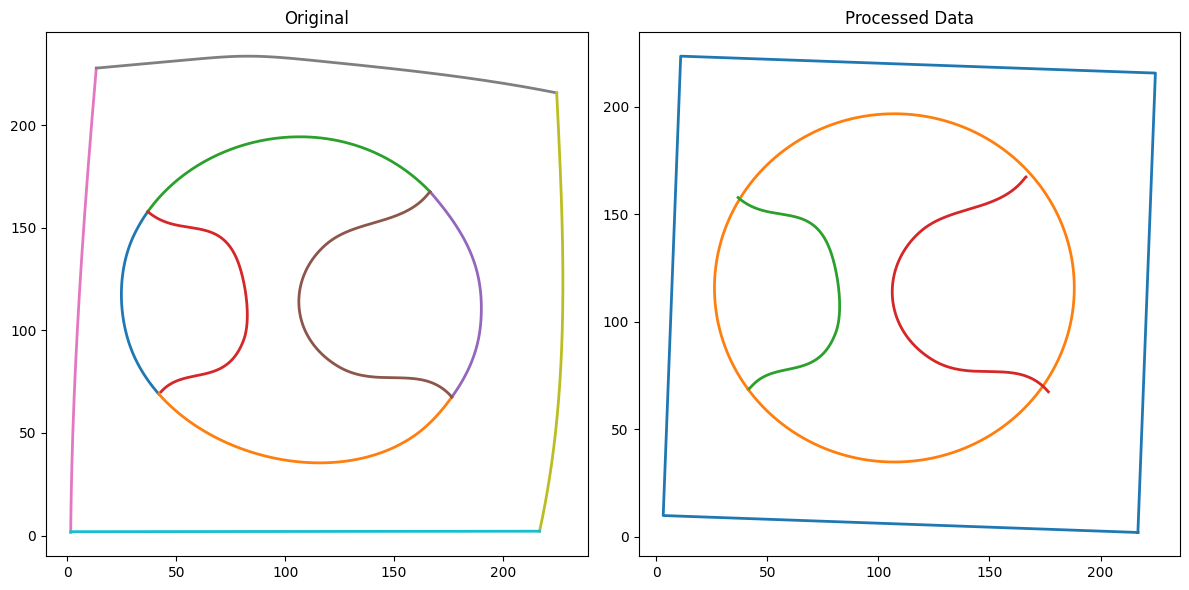

In [349]:
final_coordi = plot_output('frag0.csv')

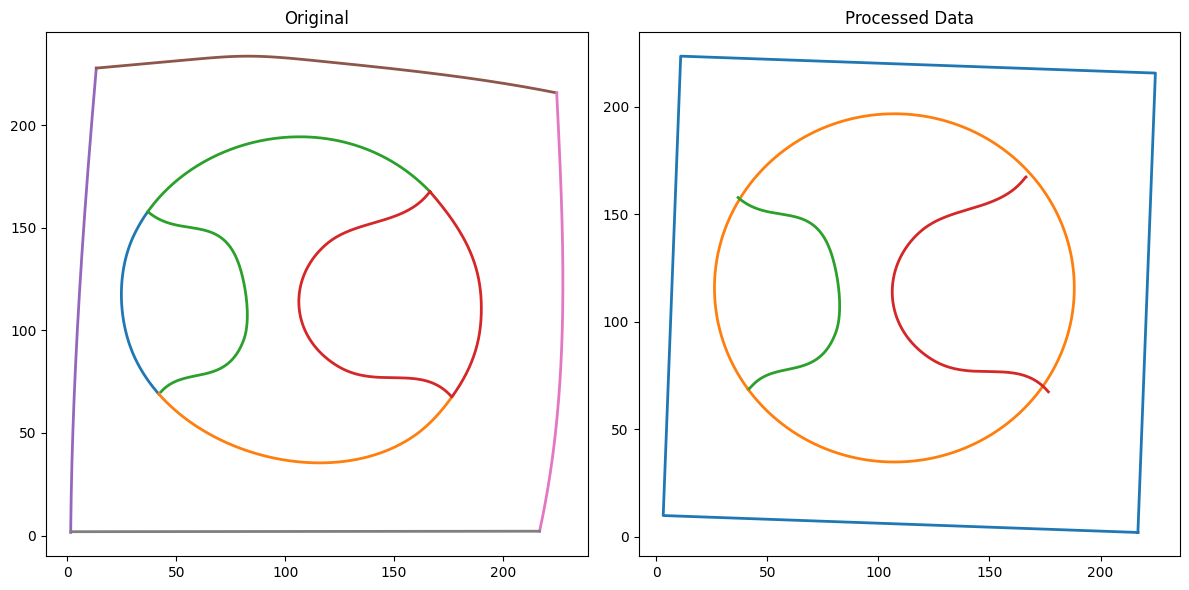

In [350]:
final_coordi = plot_output('frag1.csv')

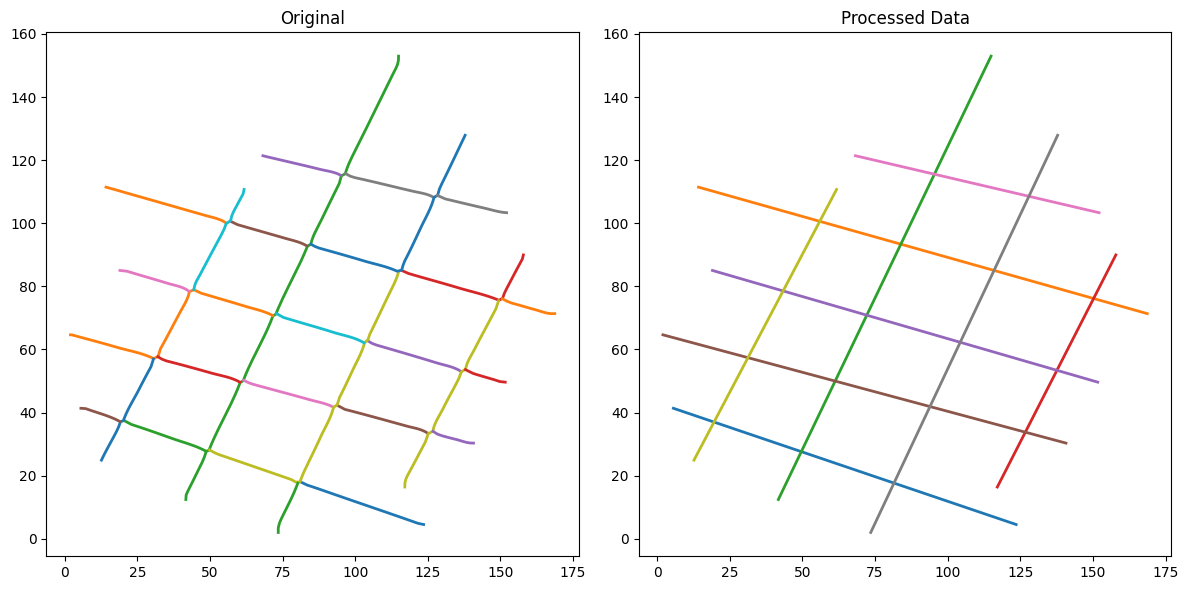

In [351]:
final_coordi = plot_output('frag2.csv')

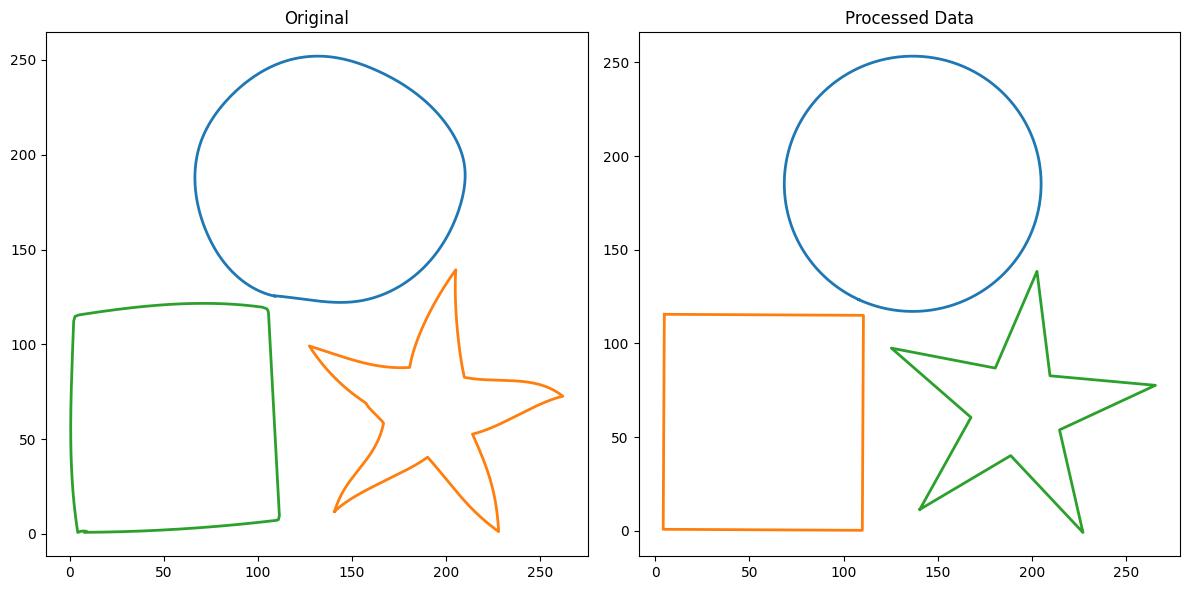

In [352]:
final_coordi = plot_output('isolated.csv')

## Saving as CSV

In [ ]:
def process_shapes_and_save_csv(final_coordi, output_csv_path):
    with open(output_csv_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['path_id', 'seg_id', 'x', 'y'])
        for path_id, shape in enumerate(final_coordi):
            # Write each point in the shape to the CSV file
            for point in shape:
                csvwriter.writerow([float(path_id), 0.0, point[0], point[1]])

In [ ]:
output_csv_path = 'shapes_output.csv'
process_shapes_and_save_csv(final_coordi, output_csv_path)